In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import shapely as shp

# make sure we are at the top of the repo
wd = subprocess.check_output('git rev-parse --show-toplevel', shell = True)
os.chdir(wd[:-1]) #-1 removes \n

In [2]:
# read in LEHD OD data
lehd = pd.read_csv('data/lehd_od_2014.csv',
 dtype = {'w_geocode':'string',
          'h_geocode':'string'})

# keep only what we need
lehd = lehd[['w_geocode','h_geocode','S000']]
lehd.columns = ['w_geocode','h_geocode','people']

In [3]:
# read in nyc census block shapefiles
nycshp = gp.read_file('data/nycb2010_16c/nycb2010.shp')

# set up cooridnate system
nycshp = nycshp.to_crs(epsg=2263) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet

# we only need manhattan 
manshp = nycshp[nycshp.BoroName == 'Manhattan']

# add state code 36 and leading digits for county code 06
manshp['BCTCB2010'] = '3606' + manshp['BCTCB2010']

# keep only what we need
manshp = manshp[['BCTCB2010','geometry']]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
# keep only LEHD with work and home both in manhattan
lehd = lehd[np.in1d(lehd.h_geocode, manshp.BCTCB2010) & np.in1d(lehd.w_geocode, manshp.BCTCB2010)]
lehd.index = range(len(lehd))

In [5]:
# find the distance between work and home
work = lehd.merge(manshp, how = 'left', left_on = 'w_geocode', right_on = 'BCTCB2010')
work = gp.GeoDataFrame(work, crs = manshp.crs, geometry = 'geometry')
home = lehd.merge(manshp, how = 'left', left_on = 'h_geocode', right_on = 'BCTCB2010')
home = gp.GeoDataFrame(home, crs = manshp.crs, geometry = 'geometry')

# note: distance is calculated in ft - convert to miles
lehd['distance'] = home.distance(work) / 5280

In [6]:
# aggregate LEHD data to geocode level with weighted average distance to home and to work

def wavg(group):
    d = group['distance']
    w = group['people']
    return (d * w).sum() / w.sum()

lehd_work = pd.DataFrame(lehd.groupby('h_geocode', as_index = True).apply(wavg), columns = ['dist_towork'])
lehd_home = pd.DataFrame(lehd.groupby('w_geocode', as_index = True).apply(wavg), columns = ['dist_tohome'])


In [7]:
lehd.head()

,w_geocode,h_geocode,people,distance
0,360610001001001,360610039001008,1,2.861149
1,360610001001001,360610055022006,1,3.450270
2,360610001001001,360610093002000,1,4.453174
3,360610001001001,360610127002001,1,5.597140
4,360610001001001,360610130004000,1,7.133236


In [8]:
lehd_pwork = pd.DataFrame(lehd[['w_geocode','people']].groupby('w_geocode', as_index = True).sum())
lehd_pwork.columns = ['workers']
lehd_plive = pd.DataFrame(lehd[['h_geocode','people']].groupby('h_geocode', as_index = True).sum())
lehd_plive.columns = ['residents']

In [9]:
dist = lehd_home.merge(lehd_work, left_index = True, right_index = True)
dist = dist.merge(lehd_pwork, left_index = True, right_index = True)
dist = dist.merge(lehd_plive, left_index = True, right_index = True)
dist.head()

,dist_tohome,dist_towork,workers,residents
360610001001001,6.260197,5.989905,7,74
360610002011000,2.055703,2.408299,26,248
360610002012000,2.813478,2.399098,18,288
360610002012001,2.754103,2.136880,38,122
360610002021001,3.675661,2.516509,12,66


In [10]:
# create and write a shapefile with census block and average commute distance
cb_dist = manshp.merge(dist, left_on = 'BCTCB2010', right_index = True)
#cb_dist.columns = ['cb','geometry','dist_tohome', 'dist_towork', 'workers']

if not os.path.exists('data/cb_dist/'):
    os.makedirs('data/cb_dist/')
    
cb_dist.to_file('data/cb_dist/cb_dist.shp')

cb_dist.head()

,BCTCB2010,geometry,dist_tohome,dist_towork,workers,residents
3121,360610002011000,"POLYGON ((988376.7305908195 199328.6176268376,...",2.055703,2.408299,26,248
3124,360610009001000,"POLYGON ((981514.6381835958 196417.3043944138,...",5.002447,2.650625,404,253
3125,360610012001000,"POLYGON ((989107.3262329118 200969.6084105199,...",2.678028,2.212737,7,130
3126,360610014011000,"POLYGON ((987475.0164184577 200297.2178465645,...",2.958618,2.119801,76,239
3127,360610015021000,"POLYGON ((982102.8818359384 198029.1682249822,...",5.390898,2.498184,107,183


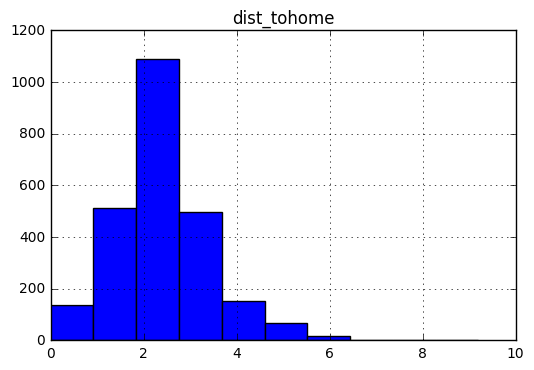

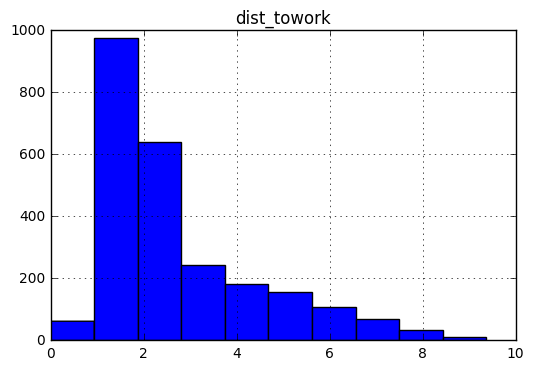

In [11]:
import pylab as pl
cb_dist.hist('dist_tohome')
cb_dist.hist('dist_towork')
pl.show()